In [138]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


cuda


## Task 1

### read my dataset,
source: https://www.manythings.org/anki/Mandarin Chinese - English cmn-eng.zip (30979)

In [139]:
def load_zh_en_tatoeba(path, max_samples=None):
    pairs = []
    with open(path, encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) < 2:
                continue
            en, zh = parts[0].strip(), parts[1].strip()
            if en and zh:
                pairs.append((zh, en))

            if max_samples and len(pairs) >= max_samples:
                break
    return pairs

data = load_zh_en_tatoeba(r"D:/project/nlp/a3/data/cmn.txt", max_samples=100000)

print("Total samples:", len(data))
print("Example:", data[0])


Total samples: 30979
Example: ('嗨。', 'Hi.')


### train / val / test

In [140]:
import random
random.seed(42)
random.shuffle(data)

train_size = int(0.8 * len(data))
val_size   = int(0.1 * len(data))
test_size  = len(data) - train_size - val_size

train_data = data[:train_size]
val_data   = data[train_size:train_size+val_size]
test_data  = data[train_size+val_size:]

print(len(train_data), len(val_data), len(test_data))

24783 3097 3099


### tokenizer

- **Chinese (ZH):** We use the *jieba* tokenizer, which performs word segmentation suitable for Chinese text where words are not explicitly separated by spaces.
  
- **English (EN):** We use the *spaCy* tokenizer (`en_core_web_sm`), which provides high-quality tokenization based on linguistic rules and pretrained models.

In [141]:
import jieba
from torchtext.data.utils import get_tokenizer

SRC_LANGUAGE = 'zh'
TRG_LANGUAGE = 'en'

token_transform = {}
token_transform['zh'] = lambda x: list(jieba.cut(x))
token_transform['en'] = get_tokenizer('spacy', language='en_core_web_sm')



### vocab

In [226]:
from torchtext.vocab import build_vocab_from_iterator

special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

vocab_transform = {}

def yield_tokens(data, language):
    idx = 0 if language == 'zh' else 1
    for zh, en in data:
        yield token_transform[language]((zh, en)[idx])


for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_data, ln),
        min_freq=2,
        specials=special_symbols,
        special_first=True
    )
    vocab_transform[ln].set_default_index(
        vocab_transform[ln]['<unk>']
    )

PAD_IDX     = vocab_transform[TRG_LANGUAGE]['<pad>']
TRG_SOS_IDX = vocab_transform[TRG_LANGUAGE]['<sos>']
TRG_EOS_IDX = vocab_transform[TRG_LANGUAGE]['<eos>']
UNK_IDX     = vocab_transform[TRG_LANGUAGE]['<unk>']

SRC_SOS_IDX = vocab_transform[SRC_LANGUAGE]['<sos>']
SRC_EOS_IDX = vocab_transform[SRC_LANGUAGE]['<eos>']

print("SRC SOS:", SRC_SOS_IDX, "SRC EOS:", SRC_EOS_IDX)
print("TRG SOS:", TRG_SOS_IDX, "TRG EOS:", TRG_EOS_IDX)

torch.save(vocab_transform, 'models/vocab.pt')



SRC SOS: 2 SRC EOS: 3
TRG SOS: 2 TRG EOS: 3


### text→ Tensor

In [143]:
import torch

def sequential_transforms(*transforms):
    def func(txt):
        for transform in transforms:
            txt = transform(txt)
        return txt
    return func


def tensor_transform(token_ids, sos_idx, eos_idx):
    return torch.cat([
        torch.tensor([sos_idx]),
        torch.tensor(token_ids),
        torch.tensor([eos_idx])
    ])

text_transform = {}

text_transform['zh'] = sequential_transforms(
    token_transform['zh'],
    vocab_transform['zh'],
    lambda x: tensor_transform(x, SRC_SOS_IDX, SRC_EOS_IDX)
)

text_transform['en'] = sequential_transforms(
    token_transform['en'],
    vocab_transform['en'],
    lambda x: tensor_transform(x, TRG_SOS_IDX, TRG_EOS_IDX)
)


### DataLoader

In [144]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def collate_batch(batch):
    src_batch, trg_batch, src_len = [], [], []

    for zh, en in batch:
        src = text_transform['zh'](zh)
        trg = text_transform['en'](en)
        src_batch.append(src)
        trg_batch.append(trg)
        src_len.append(len(src))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)

    return src_batch, torch.tensor(src_len), trg_batch



BATCH_SIZE = 64

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch
)

val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch
)

test_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_batch
)


In [145]:
for src, src_len, trg in train_loader:
    print("SRC:", src.shape)
    print("LEN:", src_len.shape)
    print("TRG:", trg.shape)
    break



SRC: torch.Size([64, 14])
LEN: torch.Size([64])
TRG: torch.Size([64, 16])


Multi-Head Attention Layer

In [146]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.scale   = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0,2,1,3)
        
        energy = torch.matmul(Q, K.permute(0,1,3,2)) / self.scale
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(self.dropout(attention), V)
        
        x = x.permute(0,2,1,3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
        x = self.fc_o(x)
        
        return x, attention


Position-wise Feedforward Layer

In [147]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

Encoder layer

In [148]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        
        return src


Encoder

In [149]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length=100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([
            EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
            for _ in range(n_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.scale   = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        return src


Decoder Layer

In [150]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        
        self.self_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward       = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout           = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        
        _trg = self.feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        return trg, attention


Decoder

In [151]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length=100):
        super().__init__()
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([
            DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
            for _ in range(n_layers)
        ])
        
        self.fc_out  = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale   = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size,1).to(self.device)
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        output = self.fc_out(trg)
        return output, attention


Seq2Seq Transformer

In [152]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

Weight Initialization

In [153]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)


Hyperparameter Settings

In [154]:
INPUT_DIM  = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])

HID_DIM    = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS  = 8
DEC_HEADS  = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX


Build Encoder & Decoder

In [155]:
enc = Encoder(
    INPUT_DIM,
    HID_DIM,
    ENC_LAYERS,
    ENC_HEADS,
    ENC_PF_DIM,
    ENC_DROPOUT,
    device
)

dec = Decoder(
    OUTPUT_DIM,
    HID_DIM,
    DEC_LAYERS,
    DEC_HEADS,
    DEC_PF_DIM,
    DEC_DROPOUT,
    device
)


Build Seq2Seq Transformer Model

In [156]:
model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)


Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(6853, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
   

In [157]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)


1754368
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1124864
 25600
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1124864
  4394
______
8013354


Optimizer & Loss

In [158]:
import torch.optim as optim

lr = 0.0005

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)


Training Loop

In [159]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        # Remove <eos> from input
        output, _ = model(src, trg[:, :-1])
        
        output_dim = output.shape[-1]
        
        output = output.reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)   
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length


Evaluation Loop

In [160]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:, :-1])
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length


## Task 2

Putting everything together

In [161]:

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [162]:
import gc

input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
lr = 3e-4
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

num_epochs = 10
clip = 1


history = {}


for attention_var in ['general', 'additive']:

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
    val_loader   = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
    test_loader  = DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

    train_loader_length = len(list(iter(train_loader)))
    val_loader_length   = len(list(iter(val_loader)))
    test_loader_length  = len(list(iter(test_loader)))

    enc = Encoder(input_dim,
                  hid_dim,
                  enc_layers,
                  enc_heads,
                  enc_pf_dim,
                  enc_dropout,
                  device)

    dec = Decoder(output_dim,
                  hid_dim,
                  dec_layers,
                  dec_heads,
                  dec_pf_dim,
                  enc_dropout,
                  device)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    betas=(0.9, 0.98),
    eps=1e-9
)
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

    save_path = f"models/{attention_var}_{model.__class__.__name__}.pt"

    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    print(f'\n===== {attention_var.upper()} ATTENTION =====')

    for epoch in range(num_epochs):

        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, val_loader, criterion, val_loader_length)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss <= best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_path)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        
    history[attention_var] = {
        'train_loss': train_losses,
        'valid_loss': valid_losses
    }
    del enc
    del dec
    del model
    torch.cuda.empty_cache()
    gc.collect()



===== GENERAL ATTENTION =====
Epoch: 01 | Time: 0m 16s
	Train Loss: 4.331 | Train PPL:  76.028
	 Val. Loss: 3.409 |  Val. PPL:  30.224
Epoch: 02 | Time: 0m 16s
	Train Loss: 3.197 | Train PPL:  24.465
	 Val. Loss: 2.931 |  Val. PPL:  18.742
Epoch: 03 | Time: 0m 16s
	Train Loss: 2.724 | Train PPL:  15.247
	 Val. Loss: 2.638 |  Val. PPL:  13.984
Epoch: 04 | Time: 0m 16s
	Train Loss: 2.357 | Train PPL:  10.554
	 Val. Loss: 2.407 |  Val. PPL:  11.106
Epoch: 05 | Time: 0m 16s
	Train Loss: 2.054 | Train PPL:   7.797
	 Val. Loss: 2.253 |  Val. PPL:   9.517
Epoch: 06 | Time: 0m 16s
	Train Loss: 1.813 | Train PPL:   6.128
	 Val. Loss: 2.151 |  Val. PPL:   8.590
Epoch: 07 | Time: 0m 16s
	Train Loss: 1.610 | Train PPL:   5.002
	 Val. Loss: 2.056 |  Val. PPL:   7.812
Epoch: 08 | Time: 0m 17s
	Train Loss: 1.440 | Train PPL:   4.221
	 Val. Loss: 2.035 |  Val. PPL:   7.655
Epoch: 09 | Time: 0m 17s
	Train Loss: 1.294 | Train PPL:   3.649
	 Val. Loss: 2.017 |  Val. PPL:   7.517
Epoch: 10 | Time: 0m 17s

## Task 3

### BLEU Score

In [179]:
def load_model(model_path):
    enc = Encoder(
        input_dim,
        hid_dim,
        enc_layers,
        enc_heads,
        enc_pf_dim,
        enc_dropout,
        device
    )

    dec = Decoder(
        output_dim,
        hid_dim,
        dec_layers,
        dec_heads,
        dec_pf_dim,
        enc_dropout,
        device
    )

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    return model

In [180]:
def translate_sentence(src_tensor, model, max_len=50):

    model.eval()

    src_tensor = src_tensor.unsqueeze(0).to(device)   # [1, src_len]

    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [TRG_SOS_IDX]

    for _ in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(
                trg_tensor, enc_src, trg_mask, src_mask
            )

        pred_token = output.argmax(2)[:, -1].item()

        trg_indexes.append(pred_token)

        if pred_token == TRG_EOS_IDX:
            break

    return trg_indexes


In [182]:
from torchtext.data.metrics import bleu_score


SRC_PAD_IDX = vocab_transform[SRC_LANGUAGE]['<pad>']
TRG_PAD_IDX = vocab_transform[TRG_LANGUAGE]['<pad>']

SOS_IDX = vocab_transform[TRG_LANGUAGE]['<sos>']
EOS_IDX = vocab_transform[TRG_LANGUAGE]['<eos>']

PAD_IDX = TRG_PAD_IDX

def calculate_bleu(data, model):
    trgs = []
    pred_trgs = []

    model.eval()

    idx2trg = vocab_transform[TRG_LANGUAGE].get_itos()

    for batch in data:
        src, src_len, trg = batch

        src = src.to(device)
        trg = trg.to(device)

        for i in range(src.shape[0]):

            pred_tokens = translate_sentence(src[i], model)

            pred_sentence = [
                idx2trg[t] for t in pred_tokens
                if t not in [SOS_IDX, EOS_IDX, PAD_IDX]
            ]

            trg_sentence = [
                idx2trg[t] for t in trg[i].cpu().tolist()
                if t not in [SOS_IDX, EOS_IDX, PAD_IDX]
            ]

            pred_trgs.append(pred_sentence)
            trgs.append([trg_sentence])

    return bleu_score(pred_trgs, trgs)


In [183]:
general_model_path  = "models/general_Seq2SeqTransformer.pt"
additive_model_path = "models/additive_Seq2SeqTransformer.pt"

general_model  = load_model(general_model_path)
additive_model = load_model(additive_model_path)

general_bleu  = calculate_bleu(test_loader, general_model)
additive_bleu = calculate_bleu(test_loader, additive_model)

print(f"GENERAL BLEU  = {general_bleu:.4f}")
print(f"ADDITIVE BLEU = {additive_bleu:.4f}")


GENERAL BLEU  = 0.2548
ADDITIVE BLEU = 0.2520


### computational efficiency

In [220]:
import time

def inference_time(model, data_loader, num_batches=50):
    model.eval()
    start = time.time()

    with torch.no_grad():
        for i, (src, src_len, trg) in enumerate(data_loader):
            if i >= num_batches:
                break
            src = src.to(device)
            trg = trg.to(device)
            output, _ = model(src, trg)

    return (time.time() - start) / num_batches


In [221]:
t_general  = inference_time(general_model, test_loader)
t_additive = inference_time(additive_model, test_loader)

print(f"General Attention Inference Time:  {t_general:.4f} sec / batch")
print(f"Additive Attention Inference Time: {t_additive:.4f} sec / batch")


General Attention Inference Time:  0.0248 sec / batch
Additive Attention Inference Time: 0.0219 sec / batch


### Translation effect comparison

In [223]:
def compare_translation(model1, model2, data_loader, n=5):
    idx2src = vocab_transform[SRC_LANGUAGE].get_itos()
    idx2trg = vocab_transform[TRG_LANGUAGE].get_itos()

    model1.eval()
    model2.eval()

    src, src_len, trg = next(iter(data_loader))
    src, trg = src.to(device), trg.to(device)

    for i in range(n):
        pred1 = translate_sentence(src[i], model1)
        pred2 = translate_sentence(src[i], model2)

        src_sent = [idx2src[t] for t in src[i].cpu().tolist() if t not in [PAD_IDX]]
        trg_sent = [idx2trg[t] for t in trg[i].cpu().tolist() if t not in [PAD_IDX]]
        pred1_sent = [idx2trg[t] for t in pred1 if t not in [SOS_IDX, EOS_IDX, PAD_IDX]]
        pred2_sent = [idx2trg[t] for t in pred2 if t not in [SOS_IDX, EOS_IDX, PAD_IDX]]

        print("="*80)
        print("SRC:", " ".join(src_sent))
        print("GOLD:", " ".join(trg_sent))
        print("GENERAL:", " ".join(pred1_sent))
        print("ADDITIVE:", " ".join(pred2_sent))


In [224]:
compare_translation(general_model, additive_model, test_loader, n=5)


SRC: <sos> 最近 的 警察局 在 哪里 ？ <eos>
GOLD: <sos> Where is the nearest police station ? <eos>
GENERAL: Where 's the nearest police station ?
ADDITIVE: Where 's the police station ?
SRC: <sos> 我們 提供 了 <unk> <unk> 。 <eos>
GOLD: <sos> We furnished the <unk> with <unk> . <eos>
GENERAL: We <unk> with the <unk> of fire .
ADDITIVE: We <unk> the <unk> with food .
SRC: <sos> 我 的 <unk> 很 低 。 <eos>
GOLD: <sos> My blood pressure is low . <eos>
GENERAL: My blood pressure is <unk> .
ADDITIVE: My <unk> is very interesting .
SRC: <sos> 明天 他們 將離開 日本 。 <eos>
GOLD: <sos> They are leaving Japan tomorrow . <eos>
GENERAL: They are leaving Japan tomorrow .
ADDITIVE: They are leaving Japan tomorrow .
SRC: <sos> 她 企圖 自殺 。 <eos>
GOLD: <sos> She tried to <unk> suicide . <eos>
GENERAL: She attempted suicide .
ADDITIVE: She attempted suicide .


### plot Loss Comparison

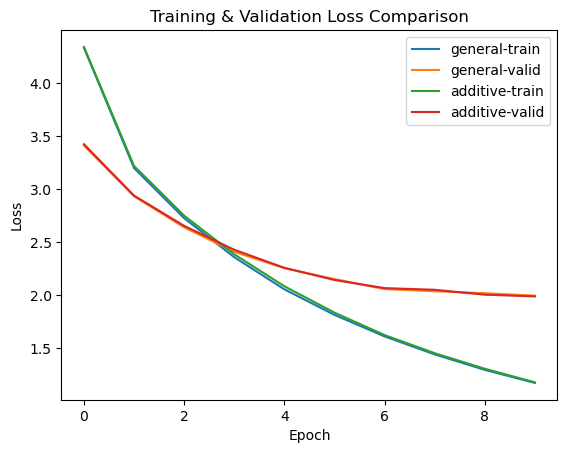

In [185]:
import matplotlib.pyplot as plt

plt.figure()
for att in history:
    plt.plot(history[att]['train_loss'], label=f'{att}-train')
    plt.plot(history[att]['valid_loss'], label=f'{att}-valid')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss Comparison')
plt.show()


### plot PPL Comparison

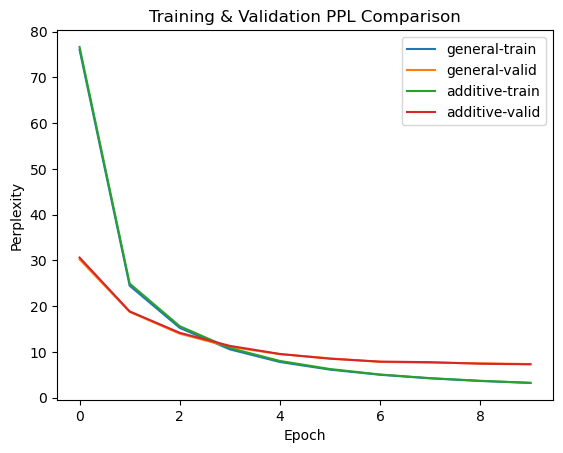

In [186]:
import math

plt.figure()
for att in history:
    train_ppl = [math.exp(x) for x in history[att]['train_loss']]
    valid_ppl = [math.exp(x) for x in history[att]['valid_loss']]

    plt.plot(train_ppl, label=f'{att}-train')
    plt.plot(valid_ppl, label=f'{att}-valid')

plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.title('Training & Validation PPL Comparison')
plt.show()


### Attention

In [215]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def display_attention(sentence, translation, attention, title="Attention"):

    attention = attention.cpu().detach().numpy()

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)

    cax = ax.matshow(attention, cmap='viridis')
    fig.colorbar(cax)

    ax.set_xticks(range(len(sentence)))
    ax.set_yticks(range(len(translation)))

    ax.set_xticklabels(sentence, rotation=45, ha='left')
    ax.set_yticklabels(translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_title(title, fontsize=15)
    plt.tight_layout()
    plt.show()


In [216]:
def decode_tokens(tensor, idx2vocab, pad_idx):
    return [idx2vocab[t] for t in tensor.cpu().tolist() if t != pad_idx]


In [217]:
src, src_len, trg = next(iter(test_loader))

src = src.to(device)
trg = trg.to(device)

print("SRC shape:", src.shape)
print("TRG shape:", trg.shape)


SRC shape: torch.Size([64, 17])
TRG shape: torch.Size([64, 16])


In [218]:
general_model.eval()
additive_model.eval()

with torch.no_grad():
    out_general,  att_general  = general_model(src, trg)
    out_additive, att_additive = additive_model(src, trg)

print("GENERAL attention shape:", att_general.shape)
print("ADDITIVE attention shape:", att_additive.shape)


GENERAL attention shape: torch.Size([64, 8, 16, 17])
ADDITIVE attention shape: torch.Size([64, 8, 16, 17])


In [219]:
attention_general  = att_general[0, 0]
attention_additive = att_additive[0, 0]

print("GENERAL:", attention_general.shape)
print("ADDITIVE:", attention_additive.shape)


GENERAL: torch.Size([16, 17])
ADDITIVE: torch.Size([16, 17])


In [213]:
idx2src = vocab_transform[SRC_LANGUAGE].get_itos()
idx2trg = vocab_transform[TRG_LANGUAGE].get_itos()

src_tokens = decode_tokens(src[0], idx2src, SRC_PAD_IDX)
trg_tokens = decode_tokens(trg[0], idx2trg, TRG_PAD_IDX)

print("SRC:", src_tokens)
print("TRG:", trg_tokens)



SRC: ['<sos>', '最近', '的', '警察局', '在', '哪里', '？', '<eos>']
TRG: ['<sos>', 'Where', 'is', 'the', 'nearest', 'police', 'station', '?', '<eos>']


C:\Users\24265\AppData\Local\Temp\ipykernel_10908\3827371490.py:25: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  plt.tight_layout()
C:\Users\24265\AppData\Local\Temp\ipykernel_10908\3827371490.py:25: UserWarning: Glyph 36817 (\N{CJK UNIFIED IDEOGRAPH-8FD1}) missing from current font.
  plt.tight_layout()
C:\Users\24265\AppData\Local\Temp\ipykernel_10908\3827371490.py:25: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
C:\Users\24265\AppData\Local\Temp\ipykernel_10908\3827371490.py:25: UserWarning: Glyph 35686 (\N{CJK UNIFIED IDEOGRAPH-8B66}) missing from current font.
  plt.tight_layout()
C:\Users\24265\AppData\Local\Temp\ipykernel_10908\3827371490.py:25: UserWarning: Glyph 23519 (\N{CJK UNIFIED IDEOGRAPH-5BDF}) missing from current font.
  plt.tight_layout()
C:\Users\24265\AppData\Local\Temp\ipykernel_10908\3827371490.py:25: UserWarning: Glyph 23616 (\N{CJK UNIFIED IDEOGRAPH-5C40}) miss

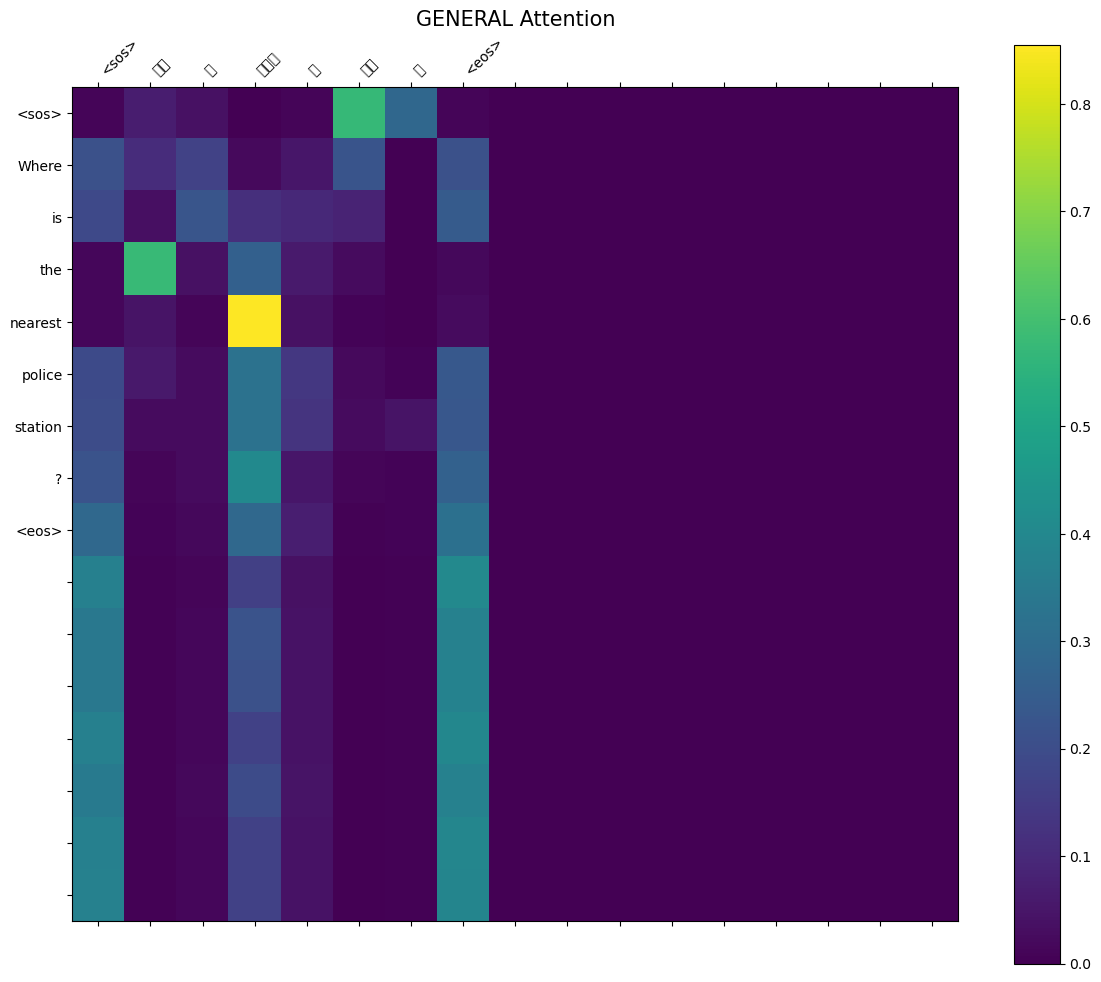

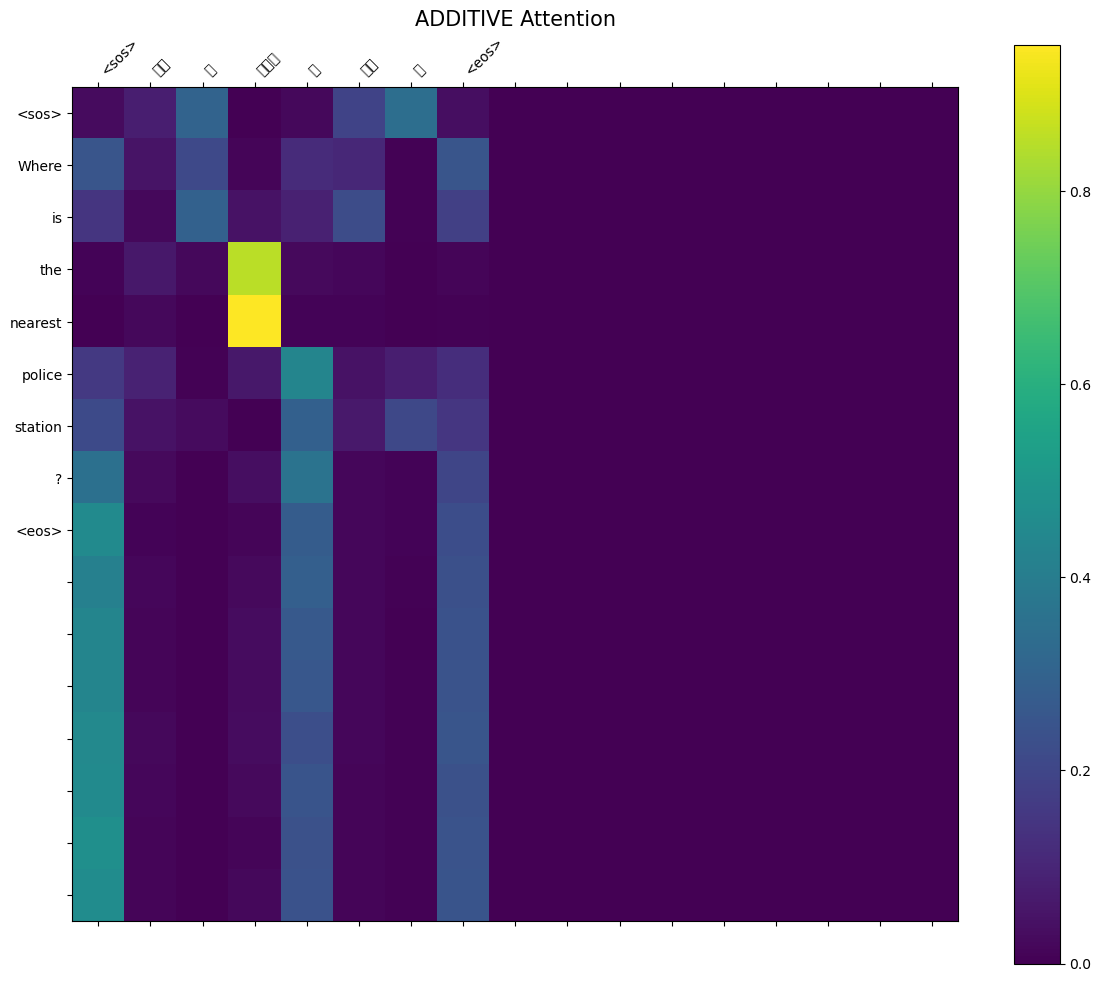

In [214]:
display_attention(src_tokens, trg_tokens, attention_general,  title='GENERAL Attention')
display_attention(src_tokens, trg_tokens, attention_additive, title='ADDITIVE Attention')


| Attention Type     | Training Loss | Training PPL | Validation Loss | Validation PPL |
| ------------------ | ------------- | ------------ | --------------- | -------------- |
| General Attention  | 1.171         | 3.226        | 1.994           | 7.343          |
| Additive Attention | 1.177         | 3.244        | 1.987           | 7.292          |


## Analysis
Experimental results show that both the general attention model and the additive attention model exhibit stable convergence during training. Both training and validation losses steadily decrease, and PPLdrops from approximately 30 to approximately 7, indicating good learning performance and strong generalization ability.

Regarding translation quality, the general attention model's BLEU score (0.2548) is slightly higher than the additive attention model's (0.2520), indicating slightly better overall translation performance. The additive attention model is slightly faster inference (0.0219 seconds per batch vs. 0.0248 seconds), but the difference is small and has little impact on practical applications.

Qualitative analysis of example translations shows that both models can generate fluent and grammatically correct sentences. The general attention model performs better in terms of semantic content, especially in location-related queries and factual statements (e.g., "Where is the nearest police station?"). The additive attention model sometimes introduces semantic bias, especially in sentences containing unfamiliar words.

Overall, the results show that the two attention mechanisms have similar performance, with the general attention mechanism having slightly higher translation accuracy and the additive attention mechanism being slightly faster.

## Task 4

![alt text](image.png)


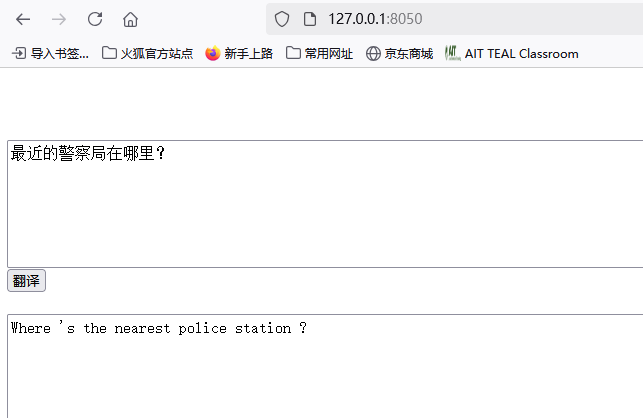